<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT19/blob/bozzato/Lab-7/bozzato_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 7: Optimization and learning**
**Bozzato Federico**

#Abstract

In this lab, we will face the optimization problem to find the independent variable that minimizes a given objective function: this kind of problems is known as *minimization problem*. Clearly, there exists also the opposite problem, that is the *maximization problem*, which algorithms are exactly the same as the ones used in this lab for the minimization problem.



#About the code

**Author:** Federico Bozzato 

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

#Set up environment

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time

import numpy as np
from numpy import linalg as la

from matplotlib import tri
from matplotlib import axes
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Introduction

When we want to minimize (or maximize) a given function $f:D\to\mathbb{R}$ with $D\subseteq\mathbb{R}^n$, we actually want to find a vector $\tilde{x}\in D$ such that

>$
  f(\tilde{x}) \le f(x) \quad \forall x \in D
$

The minimization problem is said to be *unconstrained* if $D=\mathbb{R}^n$, otherwise it is said *constrained* [1].

In this report, two of the most famous and popular algorithm will be presented. These algorithms are: *gradient descent method* and *Newton's method*.

This report is divided into three parts:

1. Methods: in this section, each algorithm is presented and explained, giving also the mathematic definition of the operation the algorithm implements.

2. Results: in this section, the results of each algorithm are presented.

3. Discussion: in this last section, results are discussed.


**Observation:** here are also provided two useful functions which calculate the gradient and the Hessian of a function. These functions are **```gradient```** and **```hessian```**.

##Useful tools

In [0]:
def gradient(fun, point, h= 0.01):  
  '''
  Calculates the gradient of the function @fun around the point @point.
  If the function @fun is a function from R -> R, then the output is the 
  first order derivative of @fun.
  Parameters:
  - fun: callable function for which the gradient is wanted
  - point: point at which the gradient is calculated
  - h (default = 0.01): interval used for approximating the gradient of the 
    function @fun
  Output:
  - gradient: vector containing the gradient calculated at the point @point
    (or the first order derivative of @fun)
  '''
  if not isinstance(point, np.ndarray):
    point= np.array(point)
    
  if point.shape == () or point.shape[0] == 1:
    n= 1
    
    return (fun(point+h) - fun(point-h)) / (2*h)
  
  else:
    n= point.shape[0]
    
    g= np.zeros((n,1))

    for i in range(n):
      p1= [x for x in point]
      p2= [x for x in point]
      
      p1[i]= p1[i] + h
      p2[i]= p2[i] - h

      g[i]= (fun(p1) - fun(p2)) / (2*h)

    return np.around(g, decimals=int(-np.log10(h))).flatten()
  
  
################################################################################
  
  
def hessian(fun, point, h= 0.01):
  '''
  Calculates the Hessian of the function @fun around the point @point.
  If the function @fun is a function from R -> R, then the output is the 
  second order derivative of @fun.
  Parameters:
  - fun: callable function for which the Hessian is wanted
  - point: point at which the Hessian is calculated
  - h (default = 0.01): interval used for approximating the Hessian of the 
    function @fun
  Output:
  - hessian: vector containing the Hessian calculated at the point @point
    (or the second order derivative of @fun)
  '''
  if not isinstance(point, np.ndarray):
    point= np.array(point)
    
  if point.shape == () or point.shape[0] == 1:
    return (fun(point+2*h) - 2*fun(point) + fun(point-2*h))/ (4*h**2)
  else:
    n= point.shape[0]
    
    hess= np.zeros((n,n))
    for i in range(n):
      p1= [x for x in point]
      p2= [x for x in point]

      p1[i]= p1[i] + h
      p2[i]= p2[i] - h

      hess[i,:]= (gradient(fun, p1, h) - gradient(fun, p2, h)) / (2*h)
      
    return hess



#Methods

This section is divided into two subsection: the mandatory part and the extra assignment.  

##Mandatory assignment

###1. Gradient descent method in $R^n$

####Definition
Gradient descent, or steepest descent method, is a first order method to find the minimum of a function, by searching for the next iterate in the direction opposite to the gradient of the objective function [2,3]. 

Gradient descent method is based on the idea that the sharpest descrease in the objective function results along the direction of the gradient. In fact, from Taylor's formula

>$
 f(x+\Delta x) - f(x)= \nabla f(x)^T\Delta x + o\left(||\Delta x||^2\right)
$

we can see that maximizing the inner product $\nabla f(x)^T\Delta x$ means to have the steepest step along the gradient direction [3]. Therefore, at each iteration, the algorithm has to calculate the gradient around the solution $x^{(x)}$. The step length $\alpha^{(k)}$ changes at each iteration and it is chosen such that the following inequality is satisfied [2]

>$
 f\left(x^{(k) }-\alpha^{(k)}\nabla f\left(x^{(k)}\right)\right) \le \beta f\left(x^{(k)}\right)
$

where the parameter $\beta < 1$.

Under some assumptions, such as $f$ is convex and $\nabla f$ is Lipschitz, $\alpha^{(k)}$ takes the form [2]

>$
 \alpha^{(k)} = \dfrac{\left(x^{(k)}-x^{(k-1)}\right)^T\left(\nabla f(x^{(k)})-\nabla f(x^{(k-1)})\right)}{||\nabla f(x^{(k)})-\nabla f(x^{(k-1)})||^2}
$

####Implementation
The algorithm used in the section is the same algorithm explained in [3] and here it is reported.


```
x(0) = initial value
while || grad(f, x(k)) || >= tol do
  determine alpha(k)
  x(k+1) = x(k) + alpha(k) * grad(f, x(k))
end
```



In [0]:
def minFinding(fun, x0, n_max= 1e6,  tol= 1e-5):
  '''
  Finds the global minimum of the function @fun starting from the initial 
  point @point. The function @fun can be either in 1 dimension or in higher 
  dimensions.
  Parameters:
  - fun: callable function for which the minimum is wanted
  - x0: initial value / point for the iterative method
  - n_max (default = 1e6): maximum number of iteration allowed
  - tol (default = 1e-5): tolerance to stop the iterations
  Output:
  - x: minimum found by using gradient descent method
  - res: residuals of the algorithm
  '''
  if not isinstance(x0, np.ndarray):
    x0= np.array(x0)
     
  k= 0                                                      # iterations counter
  
  x= x0                                                     # initial value                                               
  step= gradient(fun,x)                                     # initial step
  
  x_previous= np.zeros_like(x)                              # previous solution at step (k-1), useful for calculating alpha
  
  residuals= []                                             # residuals vector
  residuals.append(la.norm(step))
  
  start= time.time()
  while residuals[k] >= tol and k < n_max:
    grad= gradient(fun, x)                                  # gradient at step (k)
    grad_previous= gradient(fun, x_previous)                # gradient at step (k-1)
    
    if k == 0:
      alpha= np.inner(x,grad) / la.norm(grad)**2            # first step (x_previous = 0)
    else:
      num= np.inner(x-x_previous, grad - grad_previous)
      den= la.norm(grad - grad_previous)**2
      alpha=  num / den                                     # formula for alpha explained above
      
    x_previous= x
    x= x - alpha * grad                                     # update the solution
    
    res= la.norm(gradient(fun,x))
    residuals.append(res)
    k+= 1
  
  end= time.time()
  
  x= np.around(x, int(abs(np.log10(tol))))                  # round the solution with the same number of zero as in @tol
  
  print('Solution found in {} seconds with {} iterations'.format(np.around(end-start,3), k))
  return x, np.array(residuals)

##Extra assignment

###2. Newton's method in $R^n$
Gradient descent is a powerful method for searching for a minimum of a given function, but it is a first order iterative method because it uses only first order derivative: this leads to a linear convergence rate [4]. 

Instead of using the gradient descent, for some applications we may want to use different methods with a higher convergence rate, such as the Netwon's method which is a modification of gradient descent method.

####Definition
Newton's method is a gradient descent method where the step is given by the Hessian of the function to minimize.

Let $f: \mathbb{R}^n\to\mathbb{R}$ be the function to minimize. By Taylor's formula, for small variation of $x\in\mathbb{R}^n$ we have

>$
  f(x+\Delta x) \approx f(x) + \nabla f(x)^T\Delta x + \dfrac{1}{2}\Delta x^T H_f(x)\Delta x
$

where:

*  $\nabla f(x)$ is the gradient of $f$
* $H_f(x)$ is the Hessian of $f$

Now, we derive the stationary point from

>$
\dfrac{df(x)}{d(\Delta x)}= \nabla f(x) + H_f(x)\Delta x = 0 \qquad \longrightarrow  \qquad\Delta x = - H_f(x)^{-1}\nabla f(x)
$

Therefore, replacing $x + \Delta x$ with $x^{(k+1)}$ and $x$ with $x^{(k)}$, we can write the solution at step $k$ as

>$
  x^{(k+1)}= x^{(k)} - H_f\left(x^{(k)}\right)^{-1}\nabla f\left(x^{(k)}\right)
$

####Implementation
The algorithm used in the section is the same algorithm explained in [5] and here it is reported.

```
x(0) = initial value
while || grad(f, x(k)) || >= tol do
  dx = least_squares(hessian(f, x(k)), -grad(f, x(x)))
  
  x(k+1) = x(k) + dx
```



In [0]:
def newtonMinFinding(fun, x0, n_max= 1e6, tol= 1e-5):
  '''
  Finds the global minimum of the function @fun starting from the initial 
  point @point. The function @fun can be either in 1 dimension or in higher 
  dimensions.
  Parameters:
  - fun: callable function for which the minimum is wanted
  - x0: initial value / point for the iterative method
  - n_max (default = 1e6): maximum number of iteration allowed
  - tol (default = 1e-5): tolerance to stop the iterations
  Output:
  - x: minimum found by using Newton's method
  - res: residuals of the algorithm
  '''
  if not isinstance(x0, np.ndarray):
    x0= np.array(x0)
    
  k= 0                                                     # interations counter
  x= x0                                                    # initial value
  step= gradient(fun, x)                                   # initial step
  
  residuals= []
  residuals.append(la.norm(step))
  start= time.time()
  while residuals[k] >= tol and k < n_max:
    hess= hessian(fun, x)                                  # hessian or 2nd order derivative
    if hess.shape == () or hess.shape[0] == 1:
      dx= -step / hess                                     # 1D case -> hess is the 2nd order derivative
    else:
      dx= la.lstsq(hess, -step, rcond=None)[0]             # nD case -> hess is the Hessian
    
    x= x + dx                                              # update the solution
    step= gradient(fun, x)                                 # new step
    residuals.append(la.norm(step))
    k+= 1
  end= time.time()
  
  x= np.around(x, int(abs(np.log10(tol))))                 # round the solution with the same number of zero as in @tol
  
  print('Solution found in {} seconds with {} iterations'.format(np.around(end-start,3), k))
  return x, np.array(residuals)

###3. Augmented Lagrangian method in $R^n$

**Input**: objective function f(x), constraints g(x) = c

**Output**: stationary point x* such that || dL/dx(x*) || < TOL

**Test**: verify accuracy and convergence with respect to exact solution 

In [0]:
# http://www.cis.pku.edu.cn/faculty/vision/zlin/Publications/ALM-v5.pdf

def augLagrangianMinimization(f, g, x0, tol= 1e-5):
  
  def augmentedLagrangian(f, g, gamma, n, m):
    
    lagr= lambda var: f(var[0:n]) - np.inner(var[n:n+m],g(var[0:n])) + gamma/2*la.norm(g(var[0:n]))**2
    
    return lagr

  
  if not isinstance(x0, np.ndarray):
    x0= np.array(x0)
  
  if x0.shape == () or x0.shape[0] == 1:
    n= 1
  else:
    n= x0.shape[0]
    
  tmp= g(x0)
  if tmp.shape == () or tmp.shape[0] == 1:               # m is the dimension of
    m= 1                                                 # lambda vector
  else:
    m= tmp.shape[0]
  
  x= np.zeros((n+m,))
  x[0:n]= x0
  
  gamma= 1.1                                           # regularisation parameter
                                                       # at 1st step
  lagr= augmentedLagrangian(f, g, gamma, n, m)
  k= 0
  step= gradient(lagr, x)
  
  residuals= []  
  residuals.append(la.norm(step))
  while residuals[k] >= tol and k < 1000000:
    
    hess= hessian(lagr, x)
    if hess.shape == () or hess.shape[0] == 1:
      dx= -step / hess
    else:
      dx= la.lstsq(hess, -step, rcond=None)[0]
    
    #print('Hessian= \n', hess)
    #print(type(x), ' and x.shape= ', x.shape)
    #print(type(dx), ' and dx.shape= ', dx.shape)
     
    x= x + dx
    #x[0:n]= x[0:n] + dx[0:n]
    #x[n:n+m]= x[n:n+m] + gamma*(g(x[0:n]))
    gamma= 1.5*gamma                                   # beta = 1.2                     
    
    lagr= augmentedLagrangian(f, g, gamma, n, m)
    
    step= gradient(lagr, x)
    residuals.append(la.norm(step))
    k+= 1
  
  print('Convergence after {} iterations'.format(k))
  return x[0:n].flatten(), np.array(residuals)

#Results
Contrary to the previous labs, the results for **```minFinding```** and **```newtonMinFinding```** are provided together to better see the differences between these two methods of minimization.

Even though the two functions can handle functions in $n$ dimensions with $n>2$, they will be tested only in 1D and 2D due to the impossibility to plot functions in higher dimensions.

The functions **```minFinding```** and **```newtonMinFinding```** are tested with the following functions:

##Functions in 1D
1. $\displaystyle\min_x~(x^4 - 3x^3 + 2) = 2.25$,  calculated manually
2. $\displaystyle \min_x~x^2e^{-x} = 0$, calculated manually
3. $\displaystyle \min_x~\sqrt{|x|} = 0$, calculated manually

##Function in 2D
1. $\displaystyle \min_{(x,y)\in\mathbb{R}^2} \left(x^2 + (y-1)^2\right) = (0,1)$,  calculated manually
2. $\displaystyle \min_{(x,y)\in\mathbb{R}^2} \left(2(x-10)^2 + (y+5)^2e^{-x+2}\right)= (10,5)$, calculated manually



In [0]:
def minimization(fun, x0, method, str_fun, n_max= 1e6, tol= 1e-5):  
  
  if method == 'newton':
    minimizer= newtonMinFinding
  elif method == 'gradient descent':
    minimizer= minFinding
  
  if not isinstance(x0, np.ndarray):
    x0= np.array(x0)
  
  
  x, res= minimizer(fun, x0, n_max, tol)
  
  
  if x0.shape == () or x0.shape[0] == 1:
    interval= np.arange(x-1, x+1, 0.001)

    plt.figure()
    plt.plot(interval, fun(interval))
    plt.plot(x, fun(x), 'ro')
    plt.title('METHOD: {} - argmin( {} )= {}'.format(method, str_fun, x))
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()

    plt.figure()
    plt.loglog([x for x in range(0,res.shape[0])], res, 'o-')
    plt.title('Residuals')
    plt.xlabel('log10( iterations )')
    plt.ylabel('log10( residuals )')
    plt.show()
  
  elif x0.shape == (2,1) or x0.shape == (1,2) or x0.shape == (2,):
    
    print('Solution x= ', x)
    
    plt.figure()
    plt.loglog([x for x in range(0,res.shape[0])], res, 'o-')
    plt.title('Residuals')
    plt.show()
    
  return x
  

##1 dimension



################################################################################
#############                    1st exercise                      #############
################################################################################


Solution found in 19.204 seconds with 648942 iterations


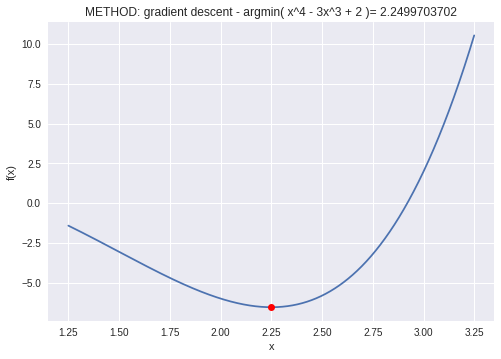

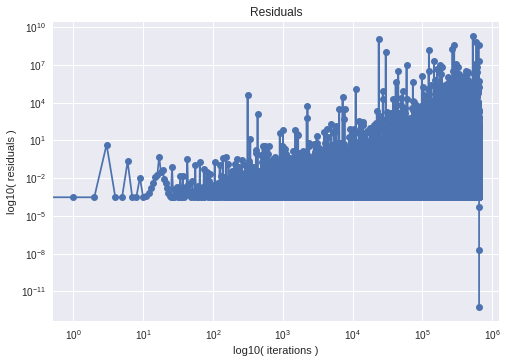

Solution found in 0.011 seconds with 262 iterations


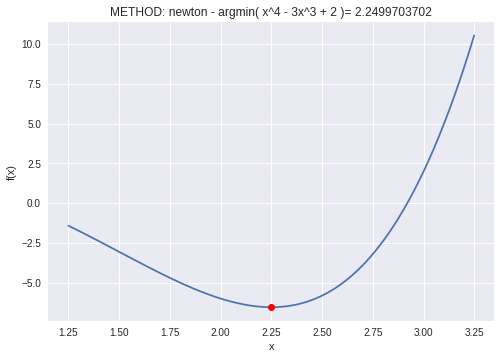

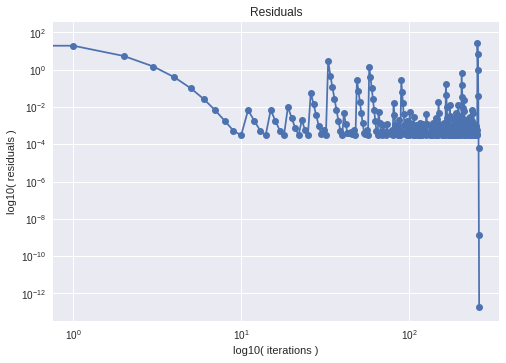

Errors: 3e-05 (GD), 3e-05 (NM)




################################################################################
#############                    2nd exercise                      #############
################################################################################


Solution found in 0.0 seconds with 4 iterations


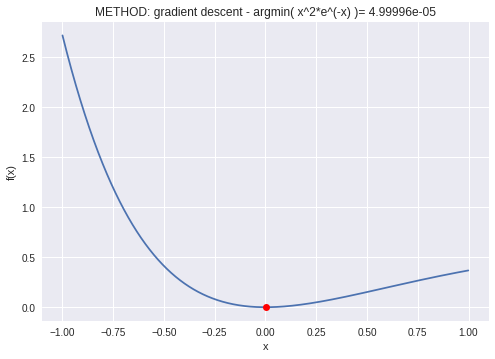

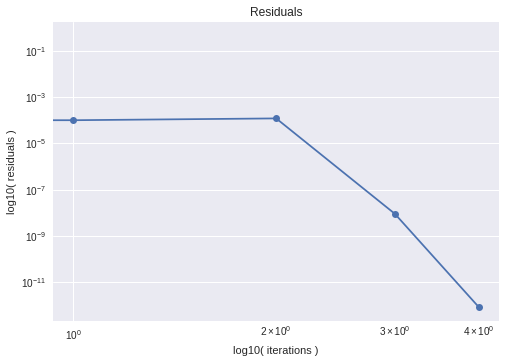

Solution found in 0.0 seconds with 11 iterations


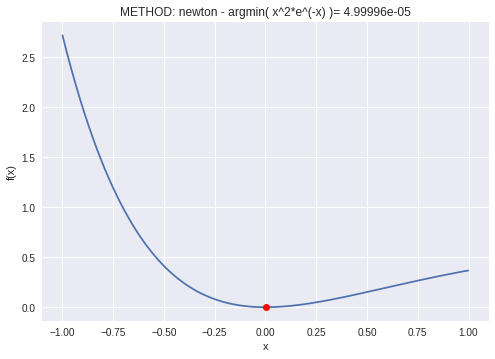

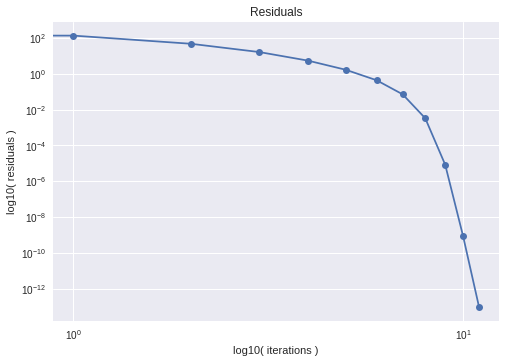

Errors: 5e-05 (GD), 5e-05 (NM)




################################################################################
#############                    3rd exercise                      #############
################################################################################


Solution found in 0.0 seconds with 1 iterations


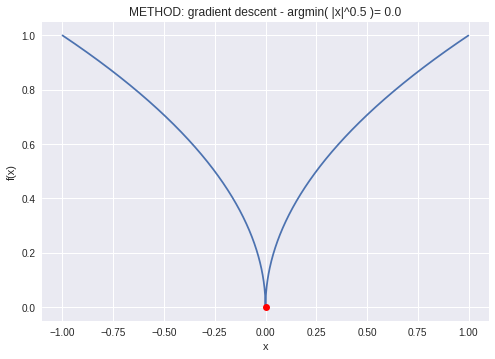

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


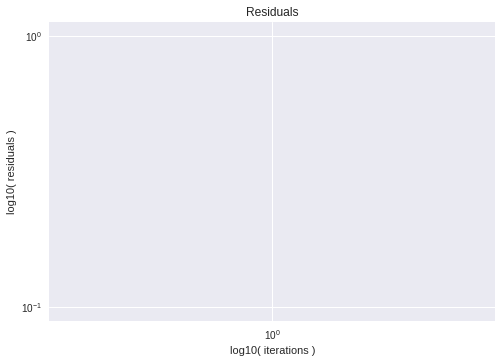

Solution found in 0.002 seconds with 13 iterations


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


ValueError: ignored

In [8]:
print('################################################################################')
print('#############                    1st exercise                      #############')
print('################################################################################')
print('\n')

f= lambda x: x**4 - 3*x**3 + 2

exact= 2.25

x0= -2
x1= minimization(f, x0, 'gradient descent', 'x^4 - 3x^3 + 2', tol= 1e-10)
x2= minimization(f, x0, 'newton', 'x^4 - 3x^3 + 2', tol= 1e-10)

err1= np.abs(x1-exact)
err2= np.abs(x2-exact)

print('Errors: {:.2} (GD), {:.2} (NM)'.format(err1,err2))
print('\n\n\n')

print('################################################################################')
print('#############                    2nd exercise                      #############')
print('################################################################################')
print('\n')

f= lambda x: x**2*np.e**(-x)

exact= 0

x0= 0.5
x1= minimization(f, x0, 'gradient descent', 'x^2*e^(-x)', tol= 1e-10)
x2= minimization(f, x0, 'newton', 'x^2*e^(-x)', tol= 1e-10)

err1= np.abs(x1-exact)
err2= np.abs(x2-exact)

print('Errors: {:.2} (GD), {:.2} (NM)'.format(err1,err2))
print('\n\n\n')



print('################################################################################')
print('#############                    3rd exercise                      #############')
print('################################################################################')
print('\n')

f= lambda x: np.sqrt(np.abs(x))

exact= 0

x0= 5
x1= minimization(f, x0, 'gradient descent', '|x|^0.5', tol= 1e-10)
x2= minimization(f, x0, 'newton', '|x|^0.5', tol= 1e-10)

err1= np.abs(x1-exact)
err2= np.abs(x2-exact)

print('Errors: {:.2} (GD), {:.2} (NM)'.format(err1,err2))

##2 dimensions

################################################################################
#############                    1st exercise                      #############
################################################################################


Solution found in 0.001 seconds with 3 iterations
Solution x=  [0.00158 1.00013]


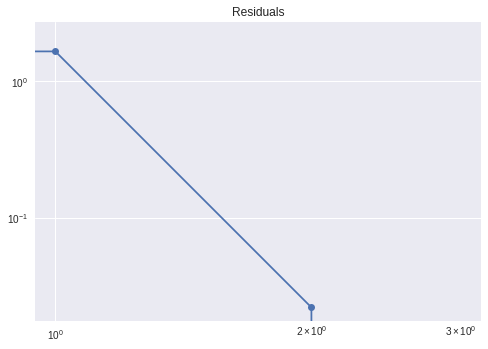

Solution found in 0.001 seconds with 1 iterations
Solution x=  [0. 1.]


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


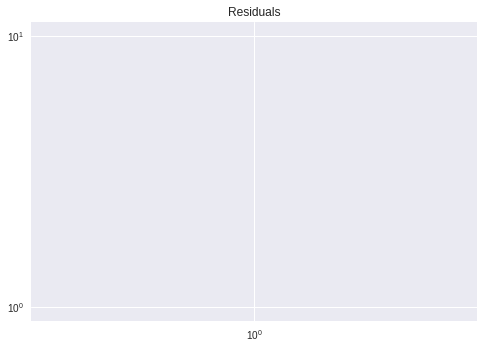

Errors: 0.0016 (GD), 0.0 (NM)




################################################################################
#############                    2nd exercise                      #############
################################################################################


Solution found in 0.059 seconds with 540 iterations
Solution x=  [nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


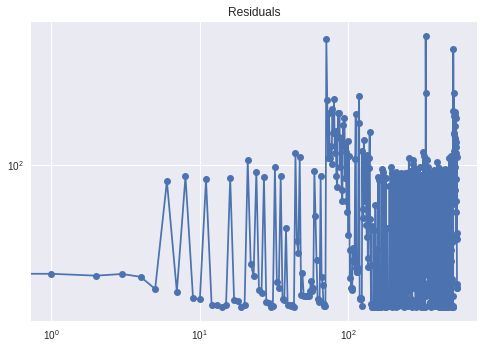

Solution found in 0.005 seconds with 15 iterations
Solution x=  [10.00077 -5.     ]


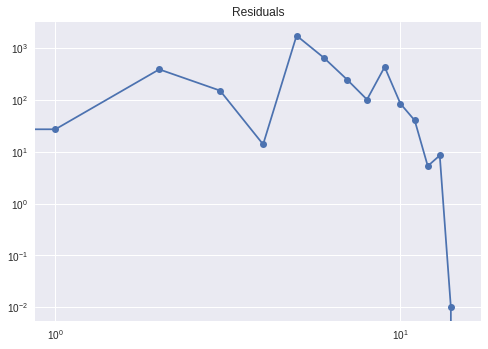

Errors: nan (GD), 0.00077 (NM)






In [20]:
print('################################################################################')
print('#############                    1st exercise                      #############')
print('################################################################################')
print('\n')

f= lambda x: x[0]**2 + (x[1]-1)**2 
x0= [0.6,0.1]

exact= [0,1]

x1= minimization(f, x0, 'gradient descent', 'x^2 + (y-1)^2')
x2= minimization(f, x0, 'newton', 'x^2 + (y-1)^2')

err1= la.norm(x1-exact)
err2= la.norm(x2-exact)

print('Errors: {:.2} (GD), {:.2} (NM)'.format(err1,err2))
print('\n\n\n')


print('################################################################################')
print('#############                    2nd exercise                      #############')
print('################################################################################')
print('\n')

f= lambda x: 2*(x[0]-10)**2 + (x[1]+5)**2*np.e**np.abs(x[0]) 
x0= [2,-1]

exact= [10,-5]

x1= minimization(f, x0, 'gradient descent', '2(x-10)^2 + (y+5)^2e^(-x+2)')
x2= minimization(f, x0, 'newton', '2(x-10)^2 + (y+5)^2e^(-x+2)')

err1= la.norm(x1-exact)
err2= la.norm(x2-exact)

print('Errors: {:.2} (GD), {:.2} (NM)'.format(err1,err2))
print('\n\n\n')

##3. Augmented Lagrangian method in $R^n$

In [0]:
f= lambda x: np.array(x[0]**2 - x[1]**2)
g= lambda x: np.array( [x[0] + x[1] - 2, x[0] -2*x[1] + 1 ]  )    # | 1  1 | | x | = | 2 |
                                                                  # | 1 -2 | | y | = |-1 |
# x = 1, x = 1

result, res= augLagrangianMinimization(f, g, [1,22])

print(f(result))
print(g(result))
print(result)

plt.figure()
plt.plot([x for x in range(0,res.shape[0])], res)
plt.show()

#Discussion

Summarize your results and your conclusions. Were the results expected or surprising. Do your results have implications outside the particular problem investigated in this report? 

#References
[1] from Lecture Notes, *Uncostrained minimization in $\mathbb{R}^n$, chapter 19*, pg.259

[2] from Wikipedia, *[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)*

[3] from Lecture Notes, *Gradient descent method, chapter 19*, pg. 260

[4] from University of British Columbia, *[CPSC 540: Machine Learning:
Gradient Descent and Newton-like Methods](https://www.cs.ubc.ca/~schmidtm/Courses/540-W17/L3.pdf)*

[5] from Lecture Notes, *Newton's method, chapter 19*, pg. 261